<a href="https://colab.research.google.com/github/tcnl/catto-or-doggo/blob/main/PyTorch_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

import os
import cv2
import numpy as np
import pandas as pd
import tqdm.notebook as tq
import time
import zipfile

from matplotlib import style
style.use("ggplot")
%matplotlib notebook

### Dowload Cats vs. Dogs Data

In [2]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2021-08-08 04:37:41--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.53.252.195, 2600:1406:3f:384::e59, 2600:1406:3f:3a0::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.53.252.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   108MB/s    in 7.6s    

2021-08-08 04:37:48 (103 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [3]:
with zipfile.ZipFile("/content/kagglecatsanddogs_3367a.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

### Creating Database Class

In [4]:
REBUILD_DATA = True
IMG_SIZE = 150

In [5]:
class DogsVSCats():
  IMG_SIZE = IMG_SIZE
  DOGS = "./PetImages/Dog"
  CATS = "./PetImages/Cat"
  LABELS = {CATS: 0, DOGS: 1}

  training_data = []
  catcount = 0
  dogcount = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tq.tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

          if label == self.CATS:
            self.catcount += 1
          elif label == self.DOGS:
            self.dogcount += 1 
        except Exception as e:
          #print(str(e))
          pass
    
    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)
    print("cats: ", self.catcount)
    print("dogs: ", self.dogcount)

In [6]:
if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()

./PetImages/Cat



./PetImages/Dog


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


cats:  12476
dogs:  12470


In [7]:
training_data = np.load("./training_data.npy", allow_pickle=True)

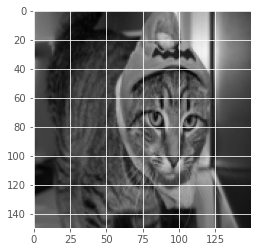

In [8]:
plt.imshow(training_data[5][0], cmap="gray")
plt.show()

### Creating Network Class

In [9]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(IMG_SIZE,IMG_SIZE).view(-1,1,IMG_SIZE,IMG_SIZE)
    self._to_linear= None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]     
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)


In [10]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, IMG_SIZE, IMG_SIZE)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data]) 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [11]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [12]:
net = Net()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


In [14]:
#Net to GPU (or CPU if no CUDA GPU is available)
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

### Plotting Graphs

In [ ]:
MODEL_NAME = f"model-{int(time.time())}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.00005)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
  BATCH_SIZE = 100
  EPOCHS = 8
  with open("model.log", "a") as f:
    for epoch in range(EPOCHS):
      for i in tq.tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,IMG_SIZE,IMG_SIZE).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        acc, loss = fwd_pass(batch_X, batch_y, train=True)
        if i % 50 == 0:
          val_acc, val_loss = test(size=100)
          f.write(f"{MODEL_NAME},{round(time.time(),3)}, {round(float(acc),2)}, {round(float(loss),4)}, {round(float(val_acc),2)}, {round(float(val_loss),4)}, {epoch}\n")


model-1628315586


In [ ]:
train()

In [ ]:
def create_acc_loss_graph(model_name):
  contents = open("model.log", "r").read().split('\n')

  times = []
  accuracies = []
  losses = []

  val_accs = []
  val_losses = []

  for c in contents:
    if model_name in c:
      name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

      times.append(float(timestamp))
      accuracies.append(float(acc))
      losses.append(float(loss))

      val_accs.append(float(val_acc))
      val_losses.append(float(val_loss))

  df = pd.read_csv("model.log",index_col=False, names=["name", "times", "train_acc", "train_loss", "test_acc", "test_loss", "epoch"], sep=",", )
  df = df.loc[df['name'] == model_name]
  df['train_acc_mva'] = df['train_acc'].ewm(alpha=.02).mean()  # exponential weighted moving average
  df['test_acc_mva'] = df['test_acc'].ewm(alpha=.02).mean()
  df['train_loss_mva'] = df['train_loss'].ewm(alpha=.02).mean()
  df['test_loss_mva'] = df['test_loss'].ewm(alpha=.02).mean()

  df.plot(x='epoch', y=['train_acc_mva', 'test_acc_mva'], figsize=(8,4))
  plt.ylabel("Accuracy")
  df.plot(x='epoch', y=['train_loss_mva', 'test_loss_mva'], figsize=(8,4))
  plt.ylabel("Loss")

  plt.show()


  #fig = plt.figure()

  #ax1 = plt.subplot2grid((2, 1), (0, 0))
  #ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

  #ax1.plot(times, accuracies, label="acc")
  #ax1.plot(times, val_acc, label="val_acc")
  #ax1.legend(loc=2)

  #ax2.plot(times, losses, label="losess")
  #ax2.plot(times, val_losses, label="val_loss")
  #ax2.legend(loc=2)

  #plt.show()


      

In [ ]:
create_acc_loss_graph(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training Network

In [ ]:
EPOCHS = 1
BATCH_SIZE = 64

In [ ]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()

  return acc, loss

In [ ]:
def test(size=32):
  random_start = np.random.randint(len(test_X)-size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1,1,IMG_SIZE,IMG_SIZE).to(device),y.to(device))
  return val_acc, val_loss


In [ ]:
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.00005)
    loss_function = nn.MSELoss()
    best_loss = 1
    for epoch in tq.tqdm(range(EPOCHS)):
        for i in tq.tqdm(range(0, len(train_X), BATCH_SIZE)): # 100 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, IMG_SIZE, IMG_SIZE)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    # Does the update
            if loss < best_loss:
              torch.save(net.state_dict(), "./CatsVsDogs_0.net")
              best_loss = loss

        print(f"\nEpoch: {epoch}. Loss: {loss}")

In [ ]:
loss_function = nn.MSELoss()
val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

0.75 tensor(0.1867, device='cuda:0')


In [ ]:
train(net)

KeyboardInterrupt: ignored

### Testing the Network

In [ ]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tq.tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, IMG_SIZE, IMG_SIZE).to(device))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

In [ ]:
test(net)


Accuracy:  0.698
